In [130]:
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

In [131]:
# SPDX-License-Identifier: BSD-3-Clause
# Turn down for faster convergence
t0 = time.time()
train_samples = 5000

# # Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)


Sparsity with L1 penalty: 80.83%
Test score with L1 penalty: 0.8361
Example run in 6.253 s


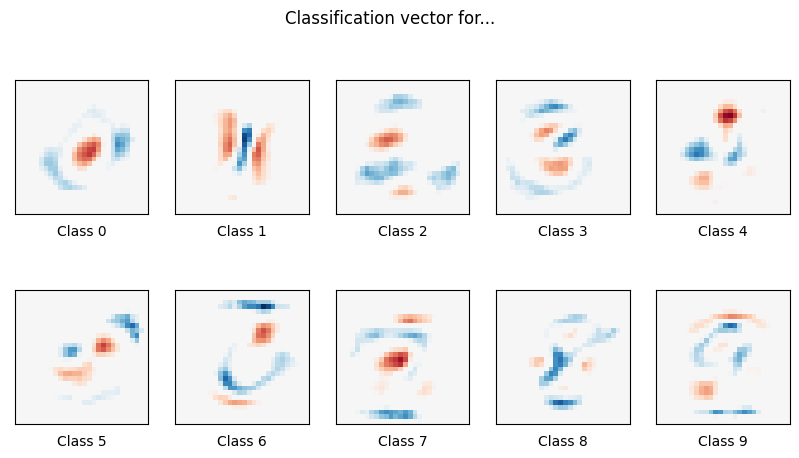

In [132]:
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50.0 / train_samples, penalty="l1", solver="saga", tol=0.1)
clf.fit(X_train, y_train)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(
        coef[i].reshape(28, 28),
        interpolation="nearest",
        cmap=plt.cm.RdBu,
        vmin=-scale,
        vmax=scale,
    )
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Class %i" % i)
plt.suptitle("Classification vector for...")

run_time = time.time() - t0
print("Example run in %.3f s" % run_time)
plt.show()

In [133]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
(clf.score(X_test, y_test))


0.8782

In [134]:
# FFNN from Sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Normalize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2 hidden layers (100 neurons each)
ffnn = MLPClassifier(hidden_layer_sizes=(200, 200), activation='relu', solver='adam', max_iter=50)
ffnn.fit(X_train, y_train)
ffnn.score(X_test, y_test)

0.9337

COBA2

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from utils import ActivationFunction, LossFunction, Derivative
import numpy as np
import json
from sklearn.metrics import confusion_matrix
%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

class FFNN:
    def __init__(self, layers, activation_functions, loss_function="mse", weight_method='xavier', seed=None, low_bound = -1, up_bound = 1, mean = 0.0, variance = 0.1, regularization=None, lambda_reg=0.01,):
        self.layers = layers
        self.activation_functions = activation_functions
        self.loss_function = loss_function
        self.weight_method = weight_method
        # karena tidak menghitung layer input
        self.num_layers = len(layers) - 1
        self.seed = seed
        self.low_bound = low_bound
        self.up_bound = up_bound
        self.mean = mean
        self.variance = variance
        self.regularization = regularization
        self.lambda_reg = lambda_reg

        self.weights = []
        self.biases = []
        self.gradients = []

        # agar hasil random bisa sama untuk seed sama
        if seed is not None:
            np.random.seed(seed)

        self.weights, self.biases = self.initialize_weights(weight_method)

    def save_model(self, file_path):
        model_data = {
            "layers": self.layers,
            "activation_functions": self.activation_functions,
            "loss_function": self.loss_function,
            "weight_method": self.weight_method,
            "mean": self.mean,
            "variance": self.variance,
            "low_bound": self.low_bound,
            "up_bound": self.up_bound,
            "seed": self.seed,
            "weights": [w.tolist() for w in self.weights],
            "biases": [b.tolist() for b in self.biases]
        }
        with open(file_path, "w") as f:
            json.dump(model_data, f)
        print("Model saved successfully to "+file_path)

    def load_model(self, file_path):
        with open(file_path, "r") as f:
            model_data = json.load(f)

        self.layers = model_data["layers"]
        self.activation_functions = model_data["activation_functions"]
        self.loss_function = model_data["loss_function"]
        self.weight_method = model_data["weight_method"]
        self.mean = model_data["mean"]
        self.variance = model_data["variance"]
        self.low_bound = model_data["low_bound"]
        self.up_bound = model_data["up_bound"]
        self.seed = model_data["seed"]
        self.weights = [np.array(w) for w in model_data["weights"]]
        self.biases = [np.array(b) for b in model_data["biases"]]

        print("Model loaded successfully from "+file_path)


    def initialize_weights(self, method):
        weights = []
        biases = []
        for i in range (self.num_layers):
            if (method == "zero"):
                w = np.zeros((self.layers[i],self.layers[i+1]))
                b = np.zeros((1, self.layers[i+1]))
            elif (method == "uniform"):
                w = np.random.uniform(self.low_bound, self.up_bound, (self.layers[i],self.layers[i+1]))
                b = np.random.uniform(self.low_bound, self.up_bound, (1,self.layers[i+1]))
            elif (method == "normal"):
                deviation = np.sqrt(self.variance)
                w = np.random.normal(self.mean, deviation, (self.layers[i],self.layers[i+1]))
                b = np.random.normal(self.mean, deviation, (1, self.layers[i+1]))
            elif method == 'xavier':
                fan_in = self.layers[i]
                fan_out = self.layers[i+1]
                limit = np.sqrt(2 / (fan_in + fan_out))
                w = np.random.normal(0, limit, (self.layers[i], self.layers[i+1]))
                b = np.zeros((1, self.layers[i+1]))
            elif method == 'he':
                fan_in = self.layers[i]
                limit = np.sqrt(2 / float(fan_in))
                w = np.random.normal(0, limit, (self.layers[i], self.layers[i+1]))
                b = np.zeros((1, self.layers[i+1]))
            else:
                raise ValueError("Method initialize weight unknown")

            weights.append(w)
            biases.append(b)
        return weights, biases

    def forward(self, input):
        a = input
        activations = [a] #out sudah dikasih aktivasi
        pre_activations = [] #net

        for i in range(self.num_layers):
            # print("Ini bias shape")
            # print(a.shape)
            # print(self.weights[i].shape)
            sigma = np.dot(a, self.weights[i]) + self.biases[i]
            pre_activations.append(sigma)

            if self.activation_functions[i] == 'linear':
                a = ActivationFunction.linear(sigma)
            elif self.activation_functions[i] == 'relu':
                a = ActivationFunction.relu(sigma)
            elif self.activation_functions[i] == 'sigmoid':
                a = ActivationFunction.sigmoid(sigma)
            elif self.activation_functions[i] == 'tanh':
                a = ActivationFunction.tanh(sigma)
            elif self.activation_functions[i] == 'softmax':
                a = ActivationFunction.softmax(sigma)
            elif self.activation_functions[i] == 'swish':
                a = ActivationFunction.swish(sigma)
            elif self.activation_functions[i] == 'softplus':
                a = ActivationFunction.softplus(sigma)
            elif self.activation_functions[i] == 'elu':
                a = ActivationFunction.elu(sigma)
            else:
                raise ValueError("Method activation unknown")
            activations.append(a)

        return activations, pre_activations

    def count_loss(self, observe, pred):
        base_loss = None
        if self.loss_function == "mse":
            base_loss = LossFunction.mse(observe, pred)
        elif self.loss_function == "binary_crossentropy":
            base_loss = LossFunction.binCrossEntropy(observe, pred)
        elif self.loss_function == "categorical_crossentropy":
            base_loss = LossFunction.catCrossEntropy(observe, pred)
        else:
            raise ValueError("Loss method unknown")

        if self.regularization == "l1":
            penalty = self.lambda_reg * sum([np.sum(np.abs(w)) for w in self.weights])
            return base_loss + penalty
        elif self.regularization == "l2":
            penalty = self.lambda_reg * sum([np.sum(w ** 2) for w in self.weights])
            return base_loss + penalty
        else:
            return base_loss

        

    def backward(self, input, output, activations, pre_activations, learning_rate):
        weight_gradient = []
        biases_gradient = []

        # BACKWARD OUTPUT
        # ∂Err/∂Out
        # print("Counting Err/Out\n")
        if self.loss_function == "mse":
            dErr_dOut = activations[-1] - output
        elif self.loss_function == "binary_crossentropy":
            dErr_dOut = activations[-1] - output
        elif self.loss_function == "categorical_crossentropy":
            dErr_dOut = activations[-1] - output
        else:
            raise ValueError("Loss method unknown")

        # ∂Out/∂Net
        # print("Counting Out/Net\n")
        if self.activation_functions[-1] == 'sigmoid':
            dOut_dNet = Derivative.sigmoid(pre_activations[-1])
        elif self.activation_functions[-1] == 'relu':
            dOut_dNet = Derivative.relu(pre_activations[-1])
        elif self.activation_functions[-1] == 'tanh':
            dOut_dNet = Derivative.tanh(pre_activations[-1])
        elif self.activation_functions[-1] == 'linear':
            dOut_dNet = Derivative.linear(pre_activations[-1])
        elif self.activation_functions[-1] == 'swish':
            dOut_dNet = Derivative.swish(pre_activations[-1])
        elif self.activation_functions[-1] == 'softplus':
            dOut_dNet = Derivative.softplus(pre_activations[-1])
        elif self.activation_functions[-1] == 'elu':
            dOut_dNet = Derivative.elu(pre_activations[-1], alpha=1.0)
        elif self.activation_functions[-1] == 'softmax':
            # print(pre_activations[-1].shape)
            s = ActivationFunction.softmax(pre_activations[-1])
            # print(s.shape)
            dOut_dNet = Derivative.softmax(pre_activations[-1])
        else:
            raise ValueError("Unknown Activation Method")

        # ∂Net/∂W
        # print("Counting Net/W\n")
        dNet_dW = activations[-2]

        # Count weight and bias
        if (self.activation_functions[-1] == 'softmax' and self.loss_function == 'categorical_crossentropy'):
            delta = dErr_dOut
        else:
            delta = dErr_dOut * dOut_dNet

        weight_gradient.append(np.dot(dNet_dW.T, delta))
        biases_gradient.append(np.sum(delta, axis=0, keepdims=True))

        # BACKWARD HIDDEN
        # output layer already processed, start from num_layers-2
        for l in range(self.num_layers - 2, -1, -1):
            activation_func = self.activation_functions[l]

            # ∂Err/∂Net
            delta = np.dot(delta, self.weights[l+1].T) * getattr(Derivative, activation_func)(pre_activations[l])

            # ∂Net/∂W
            dNet_dW = activations[l]

            # Compute gradients, insert in beginning since we went from behind
            weight_gradient.insert(0, np.dot(dNet_dW.T, delta))
            biases_gradient.insert(0, np.sum(delta, axis=0, keepdims=True))

        for l in range(self.num_layers):
            if self.regularization == "l1":
                weight_gradient[l] += self.lambda_reg * np.sign(self.weights[l])
            elif self.regularization == "l2":
                weight_gradient[l] += 2 * self.lambda_reg * self.weights[l]
            self.weights[l] -= learning_rate * weight_gradient[l]
            self.biases[l] -= learning_rate * biases_gradient[l]

        return weight_gradient, biases_gradient

    def plot_loss_curve(self, loss_history, val_loss_history=None):
        plt.plot(loss_history, label="Training Loss")
        if val_loss_history is not None:
            plt.plot(val_loss_history, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss Curve")
        plt.legend()
        plt.show()

    def plot_weight_distribution(self):
        for i, weight in enumerate(self.weights):
            plt.hist(weight.flatten(), bins=50)
            plt.title(f'Weight Distribution for Layer {i + 1}')
            plt.xlabel('Weight Value')
            plt.ylabel('Frequency')
            plt.show()

    def plot_gradient_distribution(self):
        for i, gradient in enumerate(self.gradients):
            plt.hist(gradient.flatten(), bins=50)
            plt.title(f'Gradient Distribution for Layer {i + 1}')
            plt.xlabel('Gradient Value')
            plt.ylabel('Frequency')
            plt.show()

    def plot_confusion_matrix(self, X_test, y_test):
        activations, _ = self.forward(X_test)
        y_pred = np.argmax(activations[-1], axis=1)
        cm = confusion_matrix(y_test, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(10), yticklabels=np.arange(10))
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()
        
    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=50, learning_rate=0.01, batch_size=32, verbose=True):
        num_samples = X_train.shape[0]
        loss_history = []  # Menyimpan loss training history
        val_loss_history = []  # Menyimpan loss validation history
        encoder = OneHotEncoder(sparse_output=False)
        y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1)) 

        if X_val is not None and y_val is not None:
            y_val_encoded = encoder.transform(y_val.reshape(-1, 1))

        for epoch in range(epochs):
            # Shuffle data at each epoch
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            X_train, y_train_encoded = X_train[indices], y_train_encoded[indices]

            epoch_loss = 0
            for i in range(0, num_samples, batch_size):
                # Mini-batch selection
                X_batch = X_train[i:i + batch_size]
                y_batch = y_train_encoded[i:i + batch_size]

                # Forward Propagation
                activations, pre_activations = self.forward(X_batch)

                # Compute loss
                loss = self.count_loss(y_batch, activations[-1])
                epoch_loss += np.mean(loss)

                # Backpropagation
                self.backward(X_batch, y_batch, activations, pre_activations, learning_rate)

            # Average loss per epoch
            epoch_loss /= (num_samples / batch_size)
            loss_history.append(epoch_loss)

            # Validasi jika data validasi ada
            if X_val is not None and y_val is not None:
                val_activations, _ = self.forward(X_val)
                val_loss = self.count_loss(y_val_encoded, val_activations[-1])
                val_loss_history.append(np.mean(val_loss))

                # Menghitung akurasi pada data validasi
                y_pred = np.argmax(val_activations[-1], axis=1)  # Ambil kelas dengan probabilitas tertinggi
                y_true = np.argmax(y_val_encoded, axis=1)  # Ambil kelas sebenarnya (juga dalam bentuk one-hot)
                accuracy = np.mean(y_pred == y_true)
                print(f"Validation Accuracy: {accuracy:.4f}")

            if verbose:
                print(f"Epoch {epoch + 1}/{epochs} - Loss: {epoch_loss:.4f}")
                if X_val is not None and y_val is not None:
                    print(f"Validation Loss: {np.mean(val_loss):.4f}")

            # self.plot_weight_distribution()  # Menampilkan distribusi bobot
            # self.plot_gradient_distribution()  # Menampilkan distribusi gradien

        # Setelah semua epoch selesai, tampilkan grafik loss
        self.plot_loss_curve(loss_history, val_loss_history)  # Grafik loss training dan validasi
        # self.plot_confusion_matrix(X_val, y_val)  # Menampilkan confusion matrix jika ada data validasi


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Validation Accuracy: 0.3176
Epoch 1/50 - Loss: 6.0519
Validation Loss: 6.0666
Validation Accuracy: 0.4259
Epoch 2/50 - Loss: 6.0366
Validation Loss: 6.0496
Validation Accuracy: 0.6549
Epoch 3/50 - Loss: 6.0201
Validation Loss: 6.0204
Validation Accuracy: 0.7110
Epoch 4/50 - Loss: 6.0052
Validation Loss: 6.0326
Validation Accuracy: 0.7349
Epoch 5/50 - Loss: 5.9988
Validation Loss: 6.0107
Validation Accuracy: 0.7476
Epoch 6/50 - Loss: 5.9941
Validation Loss: 6.0059
Validation Accuracy: 0.7483
Epoch 7/50 - Loss: 5.9914
Validation Loss: 6.0158
Validation Accuracy: 0.7568
Epoch 8/50 - Loss: 5.9890
Validation Loss: 6.0342
Validation Accuracy: 0.7717
Epoch 9/50 - Loss: 5.9874
Validation Loss: 6.0060
Validation Accuracy: 0.7702
Epoch 10/50 - Loss: 5.9856
Validation Loss: 6.0035
Validation Accuracy: 0.7778
Epoch 11/50 - Loss: 5.9837
Validation Loss: 6.0096
Validation Accuracy: 0.7798
Epoch 12/50 - Loss: 5.9824
Validation Loss: 6.0059
Validation Accuracy: 0.7994
Epoch 13/50 - Loss: 5.9808
Valida

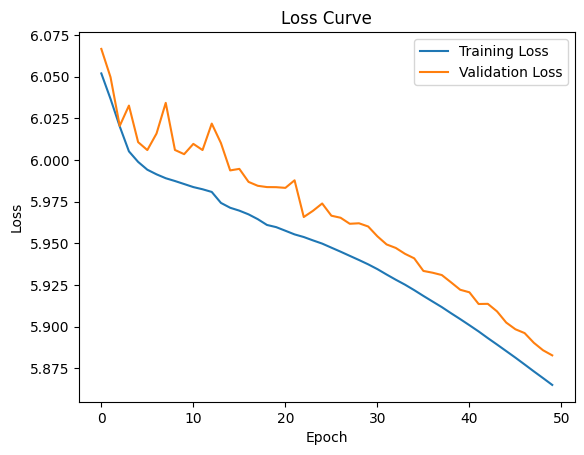

None


In [136]:
ffnn_model = FFNN(
    layers=[X_train.shape[1], 100, 100, 100, 100, 100, len(set(y_train))],  # Input, hidden 1, hidden 2, output
    activation_functions=['relu', 'relu', 'relu', 'relu', 'relu', 'relu'],
    loss_function='mse',
    weight_method='xavier',
    seed=42,
    regularization="l2"
)
a = ffnn_model.train(X_train, y_train, X_test, y_test, epochs=50, learning_rate=0.001, batch_size=200)
print(a)

Bawah ngetes bonus

In [137]:
# L1 regularisation (Lasso)
from sklearn import linear_model
lasso_reg = linear_model.Lasso(alpha=50,max_iter=100,tol=0.1)
lasso_reg.fit(X_train,y_train)

Lasso(alpha=50, max_iter=100, tol=0.1)

In [138]:
lasso_reg.score(X_test,y_test)

-0.0010026514841141587

In [139]:
# L2 regularisation (Ridge)
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=50, max_iter=100, tol=0.1)
ridge_reg.fit(X_train,y_train)

Ridge(alpha=50, max_iter=100, tol=0.1)

In [140]:
ridge_reg.score(X_test,y_test)

0.20710557959556075